# Model Evaluation and Loose Ends
## Foundations of Machine Learning
## ! git clone https://www.github.com/DS3001/model_evaluation

## Evaluating and Comparing Models
- We've covered four models: $k$ nearest neighbor, $k$ means clustering, linear models, and decision trees
- These models each introduced key ideas and skills for machine learning, and drew conceptual boundaries like supervised v. unsupervised or regression v. classification
- The risk of learning a big dictionary of models is that their common elements are obscured by an over-emphasis on their individual mechanics: These tools appear different, but we don't want to lose sight of their common features
- This lecture focuses on some general ways of evaluating whether the model is doing a "good job" or not and comparing results from models to one another
- We're building towards ideas about whether your model will actually work for "out of sample" or test predictions, rather than just perform well on the data on which it was trained: This theme will get clearer and more important as we go forward

## Loose Ends
- Before continuing with this discussion, we have some common model building tasks: Now that you know what models look like and how they're built, we want to get quickly from "clean data" to "fitted model"
- The next few slides are a variety of tasks that you typically have to do in between wrapping up data cleaning but before running an analysis
- This will offer more options for "playing" with models and comparing them, rather than just getting the basics of fitting them
- The emphasis here is on **quickly** doing routine tasks, so we don't get bogged down in code or nuance: Let's knock this stuff out so we can focus on model building and fitting
- I like to think of there being a clean `df` object, and we're now creating the `X` object that gets passed to `sklearn` modules for analysis

## Caution When Splitting for Training/Testing
- When preprocessing/feature engineering, some tasks depend on the entire vector of data (e.g. maxmin normalization) and some tasks do not (e.g. polynomial expansion)
- If you are going to do a training/test split, you should
    1. Do the tasks that do not depend on all of the data
    2. Split the data
    3. Do the tasks that require all of the data only on the training data, and save the details of the transformations to apply them to the test data
- For example, if you want to $z$-score normalize the data, save the mean and standard deviation from the training data. When you process the testing data, apply the same transformation, don't create a new one
- In practice, if you only get a single data point to make a prediction for, how would you compute its standard deviation?

## Quickly Handling `nan`'s
- You did such a great job cleaning the `nan`'s, and now they break `sklearn`. What do you do?
    1. The fastest way to handle missing values is `X.dropNA()`: It removes any row including a missing value, allowing you to move on to `sklearn`; this might be too aggressive
    2. The next simplest thing to do is replace missings with the average for that variable: `X[var] = X[var].fillna(X[var].mean())`
    3. A more ambitious thing to do is use the complete cases and $k$NN to predict values for missings; this at least maintains some of the covariance among features/variables and the target/outcome 
- Specifically for linear models, the best general approach is:
    1. Create a missing dummy variable for each variable (i.e., a vector for which $x_NA=1$ if $x$ is missing and $x_NA=0$ if $x$ is not missing, `X[varName].isnull()`)
    2. Replace each missing value with zero
- The paradox of imputation is that if you impute values and it changes the answers, your made up data is determining your results; if you impute values and it fails to influence the answers, then the imputation doesn't matter, so why are you doing it?
- There are entire books on imputation and multiple imputation

## Quick Polynomial and Interaction Features/Variables
- It it tedious to compute interaction terms like $x_1 \times x_2$ or $x^2, x^3, ..., x^m$ on your own, and it's a very common task, so `sklearn` has a convenient tool for accomplishing this
- The `PolynomialFeatures` is the object in `sklearn.preprocessing` that can quickly create matrices of exponenetiated variables for you without doing it yourself
- The basic steps are:
    1. Import the object: `from sklearn.preprocessing import PolynomialFeatures`
    2. Decide the degree of the expansion and create an expander: `expander = PolynomialFeatures(degree=2,include_bias=False)`
    3. Execute the transformations: `Z = expander.fit_transform(X)` and get labels for the columns `names = expander.get_feature_names_out()`
    4. Create a new dataframe: `zdf = pd.DataFrame(data=Z, columns = names)`
    5. Possibly concatenate this new dataframe with other data
- Use this power wisely 

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

# Example dataframe:
df = pd.DataFrame({'apples':np.array([1,3,5]),'joules':np.array([3,-2,1]), 'stocks':np.array([-2,1,4])})
X = df

In [109]:
expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
Z = expander.fit_transform(X) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
zdf = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe
zdf.head()

,apples,joules,stocks,apples^2,apples joules,apples stocks,joules^2,joules stocks,stocks^2
0,1.0,3.0,-2.0,1.0,3.0,-2.0,9.0,-6.0,4.0
1,3.0,-2.0,1.0,9.0,-6.0,3.0,4.0,-2.0,1.0
2,5.0,1.0,4.0,25.0,5.0,20.0,1.0,4.0,16.0


In [110]:
## Compute all polynomials up to degree 3:
expander = PolynomialFeatures(degree=3,include_bias=False) # Create the expander
Z = expander.fit_transform(X) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
zdf = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe
zdf.head()

,apples,joules,stocks,apples^2,apples joules,apples stocks,joules^2,joules stocks,stocks^2,apples^3,apples^2 joules,apples^2 stocks,apples joules^2,apples joules stocks,apples stocks^2,joules^3,joules^2 stocks,joules stocks^2,stocks^3
0,1.0,3.0,-2.0,1.0,3.0,-2.0,9.0,-6.0,4.0,1.0,3.0,-2.0,9.0,-6.0,4.0,27.0,-18.0,12.0,-8.0
1,3.0,-2.0,1.0,9.0,-6.0,3.0,4.0,-2.0,1.0,27.0,-18.0,9.0,12.0,-6.0,3.0,-8.0,4.0,-2.0,1.0
2,5.0,1.0,4.0,25.0,5.0,20.0,1.0,4.0,16.0,125.0,25.0,100.0,5.0,20.0,80.0,1.0,4.0,16.0,64.0


In [111]:
## Only compute the interactions up to degree 3:
expander = PolynomialFeatures(degree=3,interaction_only=True,include_bias=False) # Create the expander
Z = expander.fit_transform(X) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
zdf = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe
zdf.head()

,apples,joules,stocks,apples joules,apples stocks,joules stocks,apples joules stocks
0,1.0,3.0,-2.0,3.0,-2.0,-6.0,-6.0
1,3.0,-2.0,1.0,-6.0,3.0,-2.0,-6.0
2,5.0,1.0,4.0,5.0,20.0,4.0,20.0


## Quick One Hot Encoding
- We often have categorical data that need to be converted to numerical values for `sklearn` to work
- You can use Pandas to create dummy variables out of the categorical variable using `pd.get_dummies(varName)`
- You can use sklearn's `LabelBinarizer` to create a matrix of one-hot encoded variables
- These are the same thing

In [3]:
df = pd.DataFrame({'apples':np.array([1,3,5,7]),
                   'joules':np.array([3,-2,1,2]), 
                   'stocks':np.array([-2,1,4,6]),
                   'bird':['Cardinal','Oriole','Robin','Oriole']})
X = df
X.head()

,apples,joules,stocks,bird
0,1,3,-2,Cardinal
1,3,-2,1,Oriole
2,5,1,4,Robin
3,7,2,6,Oriole


In [4]:
# With Pandas:
ddf = pd.get_dummies(X['bird'])
ddf.head()

,Cardinal,Oriole,Robin
0,True,False,False
1,False,True,False
2,False,False,True
3,False,True,False


In [5]:
# With Pandas, if you don't like booleans:
ddf = pd.get_dummies(X['bird'],dtype='int')
ddf.head()

,Cardinal,Oriole,Robin
0,1,0,0
1,0,1,0
2,0,0,1
3,0,1,0


In [124]:
# With sklearn:
from sklearn.preprocessing import LabelBinarizer
one_hot_encoder = LabelBinarizer()

oh = one_hot_encoder.fit_transform(X['bird']) # One-hot encode the 'bird' variable
print(oh)
names = one_hot.classes_ # Get names of the classes
print(names)

zdf = pd.DataFrame( data = oh, columns = names) # Create a new df for the encoded variables
zdf.head()

[[1 0 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]]
['Cardinal' 'Oriole' 'Robin']


,Cardinal,Oriole,Robin
0,1,0,0
1,0,1,0
2,0,0,1
3,0,1,0


## Quickly Concatenating Dataframes
- OK, you made these nice shiny features, how do you get them back into a single dataframe?
- The `df = pd.concat([df1,df2,...,dfk],axis=1)` makes a new dataframe out of the columns of the original dataframes `df1`, `df2`, ..., `dfk`
- So you can build all the transformed data frames you want, then collapse them all back into one dataframe for processing
- Since you are going to do this, you might want to think carefully about how you're building the dataframe chunks, and use `.iloc` or `.loc` to be selective about what going into each one

In [44]:
## Polynomial features:
expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
Z = expander.fit_transform(df.iloc[:,1:3]) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
X1 = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe

## Dummy variables:
X2 = pd.get_dummies(df['bird'], dtype=float) # Create dummies

## Concatenate:
X = pd.concat([X1,X2],axis=1) # Concatenate engineered features
X.head()

,joules,stocks,joules^2,joules stocks,stocks^2,Cardinal,Oriole,Robin
0,3.0,-2.0,9.0,-6.0,4.0,1.0,0.0,0.0
1,-2.0,1.0,4.0,-2.0,1.0,0.0,1.0,0.0
2,1.0,4.0,1.0,4.0,16.0,0.0,0.0,1.0
3,2.0,6.0,4.0,12.0,36.0,0.0,1.0,0.0


## Quickly Handling Outliers
- We have the sense that outliers are bad, particularly for global smoothers like linear regression
- We want to (1) detect outliers, (2) create an outlier dummy, and (3) **windsorize** them: Replace values outside the whiskers with the min/max values of the whiskers (when you remove outliers altogether, it is called **trimming**)
- This is, again, a quick way of processing outliers without losing data

<Axes: >

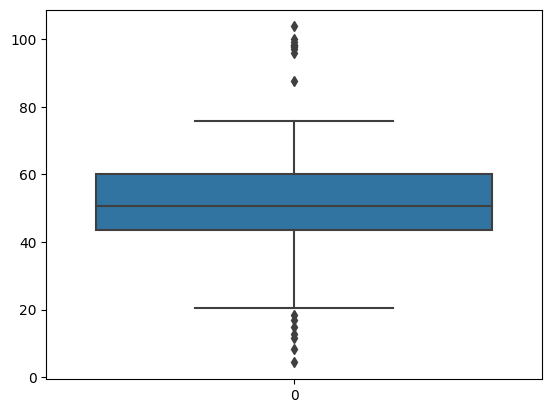

In [41]:
import seaborn as sns

## Generate random data with outliers
np.random.seed(1000)
N = 200
switch = np.random.uniform(0,1,N)
x = (switch<.05)*np.random.normal(20,10,N)+(switch >= .05)*(switch<.95)*np.random.normal(50,10,N)+(switch>=.95)*np.random.normal(100,5,N)
sns.boxplot(x)

<Axes: >

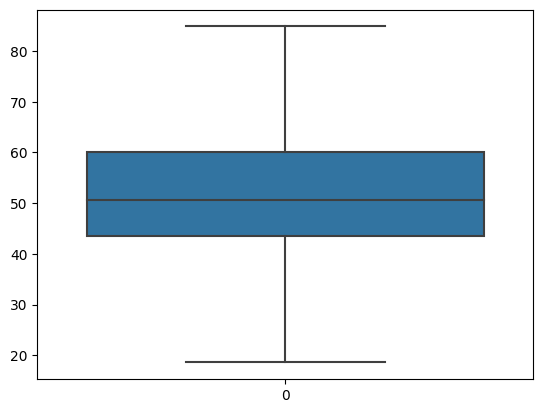

In [43]:
## Function to compute whiskers:
def windsorize(x):
    # Compute IQR and 1st,3rd quantiles
    pct1, pct3 = np.percentile(x,[25,75])
    iqr = pct3 - pct1
    # Compute whiskers:
    lower_whisker = pct1 - iqr*1.5
    upper_whisker = pct3 + iqr*1.5
    # Compute outlier dummy:
    x_outlier = (x < whiskers['lower_whisker']) + (x>whiskers['upper_whisker'])
    # Windsorize x:
    x_windsor = x
    x_windsor[ x < whiskers['lower_whisker'] ] = whiskers['lower_whisker']
    x_windsor[ x > whiskers['upper_whisker'] ] = whiskers['upper_whisker']
    return({'x_windsor':x_windsor,
            'x_outlier':x_outlier,
            'lower_whisker':lower_whisker,
            'upper_whisker':upper_whisker})

sns.boxplot( windsorize(x)['x_windsor'])

## Model Evaluation: What is a Model?
- A **model** is a function that maps cases $\hat{x}$ into predictions $\hat{y}$ using a rule $m(\hat{x},b,k) = \hat{y}$ where $b$ are **parameters** (e.g. weights in linear regression, splits in a decision tree) and $k$ are **hyperparameters** (number of neighbors in $k$NN, which variables to include in linear regression, how complex the tree is allowed to be)
- What is a hyperparameter? A hyperparameter is any feature of a model that can trivially improve fit on training data, independently of the data (e.g. $k=1$ in kNN, $k=N$ in kMC, adding more regressors in linear models, adding more splits and variables to decision trees)
- The parameters $b$ are selected using a training set, and hyperparameters $k$ are selected by comparisons of the fitted models on a testing set (e.g. the scree plot, the CART confusion matrix)
- Let's talk about regression and classification separately

## Regression
- The **predicted value** for values $\hat{x}_i$ is the output of the model, using its parameters $b$ like regression weights and hyperparameters $k$ (e.g. the variables selected or the number of neighbors or the size of the tree):
$$ \hat{y}_i = m(\hat{x}_i, b, k) $$
We often make scatterplots of the predicted and actual values to evaluate whether the predictions and true values exhibit a strong association or not: A big cloud of points with no trend at all suggests we aren't doing a great job.
- The **residual** or **error** for observation $i$ is the difference between the true outcome and the predicted value,
$$
e_i = y_i - \hat{y}_i
$$
- This is the simplest way to evaluate how far off the model is from the truth, and we often make kernel density plots of the residuals to visualize the extent to which there are still clues left in the errors about whether we're epxloiting all the data as effectively as we can

## Measures of Fit: SSE, MSE, and RMSE
- In regression settings, we typically pick our model parameters to minimize the **Sum of Squared Error**:
$$ \text{SSE}(b,k) = \sum_{i=1}^N (y_i - m(x_i,b,k))^2, $$
or **Mean Squared Error**,
$$ \text{MSE}(b,k) = \dfrac{1}{N}\sum_{i=1}^N (y_i - m(x_i,b,k))^2, $$
or **Root Mean Squared Error**,
$$ \text{RMSE}(b,k) = \sqrt{\dfrac{1}{N}\sum_{i=1}^N (y_i - m(x_i,b,k))^2}. $$
- These are all roughly the same thing, since if $(b_1,k_1)$ does better in terms of any of these metrics than $(b_2,k_2)$, then it does better for all of them
- In practice, RMSE is a bit more interpretable, and SSE is a bit more computationally easy to work with
- There are hundreds of these

## Measures of Fit: $R^2$
- The *Sum of Squared Error* (SSE) is
$$
\text{SSE} = \sum_{i=1}^N (y_i - \hat{y}_i)^2
$$
and the *Total Sum of Squares* (TSS) is
$$
\text{TSS} = \sum_{i=1}^N (y_i - \bar{y})^2, \quad \text{ where }\bar{y} = \dfrac{1}{N}\sum_{i=1}^N y_i
$$
- The $R^2$ measure or *coefficient of determination* is
$$
R^2 = 1 - \dfrac{SSE}{TSS}
$$
- This is the proportion of the variation in the data explained by the model that isn't captured by just predicting the sample average (the simplest predictor of all)

## Measures of Fit
- The mean is our simplest predictor of a numeric outcome: It doesn't use any features/covariates/controls, and just predicts the average outcome regardless of circumstance
- If you prefer to think probabilistically, let *Mean Squared Error* (MSE) be
$$
\text{MSE} = \dfrac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2
$$
and the *variance of $Y$* be
$$
\mathbb{V}[Y] = \dfrac{1}{N} \sum_{i=1}^N (y_i - \bar{y})^2,
$$
and then the $R^2$ measure can be written
$$
R^2 = \dfrac{\mathbb{V}[Y]-\text{MSE}}{\mathbb{V}[Y]},
$$ 
the proportion of the variance in $Y$ that can be explained by the model.
- On the training set, this is between 0 and 1. On a testing set, it can be negative.

## Splitting the Sample: Training and Validation
- If you fit a model and then evaluate its performance on the data you used, you are certain to overestimate the performance of the model
- Models with hyper-parameters (e.g. $k$ in $k$NN) are typically *greedy* or *trivial*: They will do better with in-sample fit as the complexity of the hyper-parameters goes to extremes, but will do poorly predicting outcomes for new data (under-fitting, over-fitting)
- This is a form of *confirmation bias*: Our models are formalizations of past outcomes, and we don't want them to be overly sensitive to the quirks of past data but instead be robust to those quirks and useful for estimating future outcomes

## Diabetes Data
- `'./data/diabetes-dataset.csv'`
- 1000 patients with characteristics like Age, BloodPressure, BMI, Insulin levels, and past Pregnancies
- Outcome is whether the patient has diabetes or not
- The goal is to predict the likelihood someone has diabetes from other health characteristics

In [159]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./data/diabetes-dataset.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [160]:
y = df['Outcome']
print(y.describe())
X = df.drop('Outcome',axis=1)
X.head()

count    2000.000000
mean        0.342000
std         0.474498
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Outcome, dtype: float64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,2,138,62,35,0,33.6,0.127,47
1,0,84,82,31,125,38.2,0.233,23
2,0,145,0,0,0,44.2,0.630,31
3,0,135,68,42,250,42.3,0.365,24
4,1,139,62,41,480,40.7,0.536,21


In [161]:
X.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.703500,121.182500,69.145500,20.935000,80.254000,32.193000,0.470930,33.090500
std,3.306063,32.068636,19.188315,16.103243,111.180534,8.149901,0.323553,11.786423
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,63.500000,0.000000,0.000000,27.375000,0.244000,24.000000
50%,3.000000,117.000000,72.000000,23.000000,40.000000,32.300000,0.376000,29.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.800000,0.624000,40.000000
max,17.000000,199.000000,122.000000,110.000000,744.000000,80.600000,2.420000,81.000000


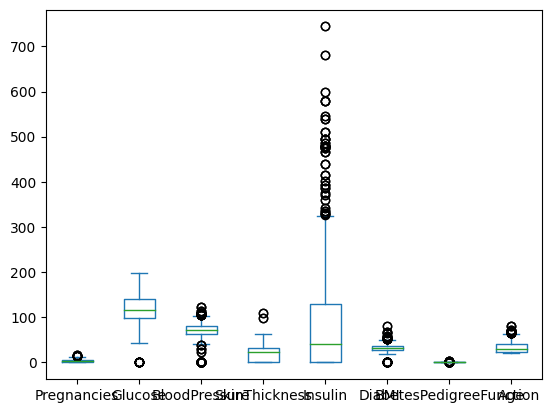

In [162]:
X.plot.box() # Hmm, insulin looks off
X['Insulin'] = np.arcsinh(X['Insulin'])

<Axes: >

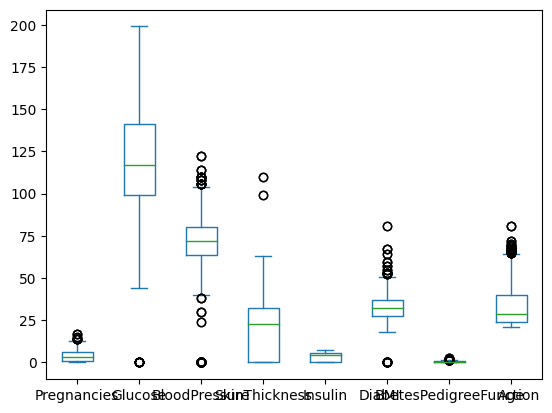

In [163]:
X.plot.box()

In [164]:
## Test-train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5000)
TSS = np.sum( (y_test - y_test.mean())**2 )
N_test = len(y_test)

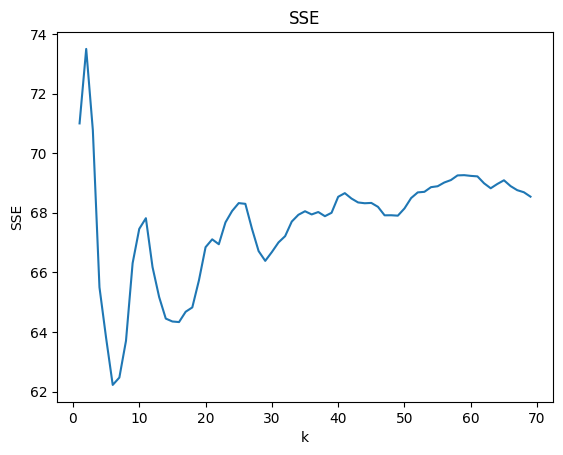

In [166]:
## kNN
from sklearn.neighbors import KNeighborsRegressor

# Maxmin normalization function:
def maxmin(z):
    z = (z-min(z))/(max(z)-min(z))
    return(z)

# Apply maxmin to each column of X:
X_train_knn = X_train.apply(maxmin)
X_test_knn = X_test.apply(maxmin)

# Determine optimal k:
k_bar = 70
k_grid = np.arange(1,k_bar) # The range of k's to consider
SSE = np.zeros(k_bar-1) # For comparison purposes, store the training error
for k in range(k_bar-1):
    model = KNeighborsRegressor(n_neighbors=k+1) # Create a sk model for k
    fitted_model = model.fit(X_train_knn,y_train) # Train the model on our data
    y_hat = fitted_model.predict(X_test_knn) # Predict values for test set
    SSE[k] = np.sum( (y_test-y_hat)**2 ) # Save the computed SSE
SSE_min = np.min(SSE) # Lowest recorded SSE
min_index = np.where(SSE==SSE_min) # Find the indices of y that equal the minimum
k_star = k_grid[min_index][0] # Find the optimal value of k

## SSE plot:
plt.plot(k_grid,SSE)
plt.xlabel("k")
plt.ylabel("SSE")
plt.title('SSE')
plt.show()

## Fit optimal model:
knn_star = KNeighborsRegressor(n_neighbors=k_star).fit(X_train_knn,y_train)
y_hat_knn = knn_star.predict(X_test_knn)

## Metrics:
SSE_knn = np.sum( (y_test-y_hat_knn)**2 )
RMSE_knn = (SSE_knn/N_test)**(1/2)
R2_knn = 1 - SSE_knn/TSS

In [108]:
## Linear Model
from sklearn.linear_model import LinearRegression # Import linear regression model
from sklearn.preprocessing import PolynomialFeatures

# Expand features
expander = PolynomialFeatures(degree=3,include_bias=False) # Create the expander
#
Z_train = expander.fit_transform(X_train) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
X_train_lm = pd.DataFrame(data=Z_train, columns = names) # Create a new, expanded dataframe
#
Z_test = expander.fit_transform(X_test) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
X_test_lm = pd.DataFrame(data=Z_test, columns = names) # Create a new, expanded dataframe

# Fit the model and get the R2 measure:
reg = LinearRegression().fit(X_train_lm, y_train) # Fit the linear model
print(reg.score(X_test_lm, y_test)) # R squared measure

# Predicted values:
y_hat_lm = reg.predict(X_test_lm)

# Metrics:
SSE_lm = np.sum( (y_test-y_hat_lm)**2 )
RMSE_lm = (SSE_lm/N_test)**(1/2)
R2_lm = 1 - SSE_lm/TSS


0.36996530832610586
0.36996530832610586


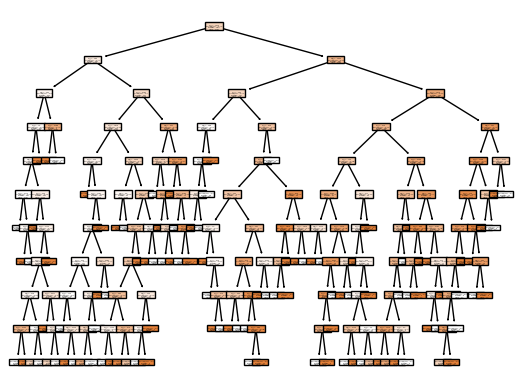

In [167]:
## Decision Trees
from sklearn import tree 

model = DecisionTreeRegressor(max_depth=10) # Fit the classifier
cart = model.fit(X_train, y_train)
tree.plot_tree(cart,filled=True) 

## Make Predictions on the Test Set
y_hat_cart = cart.predict(X_test)

## Metrics:
SSE_cart = np.sum( (y_test-y_hat_cart)**2 )
RMSE_cart = (SSE_cart/N_test)**(1/2)
R2_cart = 1 - SSE_cart/TSS


In [168]:
gdf = pd.DataFrame({'SSE':[SSE_knn,SSE_lm,SSE_cart],
                    'RMSE':[RMSE_knn,RMSE_lm,RMSE_cart],
                    'R2':[R2_knn,R2_lm,R2_cart]})
gdf.index = ['kNN','LM','CART']
gdf.head()

,SSE,RMSE,R2
kNN,62.222222,0.394405,0.326873
LM,84.827871,0.376005,0.369965
CART,28.322238,0.266093,0.693607


## Example: Credit Default
- `'./data/brazil_default.csv'`
- 50000 observations of 54 socio-economic/demographic variables on account holders in Brazil like income, age, residence type, marital status, etc.
- The target variable is whether they fail to pay their debt on the account, which is defaulting: We want to predict the probability of default

## Classification
- Suppose we want to put aside the continuous nature of the predictors, and predict categories rather than numeric values 
- Instead of thinking of the categories 0 and 1 as numbers and a prediction as a probability, think of the categories 0 and 1 as just categories with no inherent numeric meaning
- With Decision Trees and $k$NN, we can take the majority classification for those neighbors or that terminal node
- With a linear model $y = x\cdot b$, we have to round values below some threshold $s$ to 0 and above some threshold $s$ to 1; for now, let's take $s=1/2$

## Linear Models and Classification: The Binary Outcomes Case
- With Decision Trees, outcomes can be the proportion of 1's in a terminal node if impure, or a majority vote can be taken
- With $k$NN, the average of the neighbors' values can be taken as a regression prediction, or a majority vote can be taken
- - When outcome are binary (0/1), a linear model $y = x\cdot b$ provides a predicted probability of taking the value 1 (predicted values can end up being less than 0 or greater than 1, which is undesirable), or the class with the higher probability can be predicted
- Linear models, in the flavor we use, can only really do binary classification (support vector machines/linear discrimination analysis/multinomial logit are all models that use linear models as a workhorse or puzzle piece to do multiclass discrimination)

## Performance and Binary Classification
- Besides regression, many tasks require us to make categorical predictions: For a given $\hat{x}$, which of $J$ categories is it most likely to fit into?
- By far, the most common and studied case is when there are two categories, and classification is *binary*
- In this case, we can use $k$NN with a majority voting rule or case averaging, decision trees, or a linear regression of $x \cdot b$ on the $\{0,1\}$ potential outcomes
- We'll look at the main way of studying the performance of classifiers: *Confusion Matrices*

## Confusion Matrices
- We typically represent a binary classifier's performance on the testing/validation set in a cross tabulation:

|  | Predicted Negative | Predicted Positive|
| :---: | :---:| :---: |
| Actual Negative | True Negative (TN) | False Positive (FP) |
| Actual Positive | False Negative (FN) | True Positive (TP) |

- We are obviously most concerned about False Positive and False Negatives --- These are the cases in which the model can produce significant harm by failing to correctly predict the outome
- In the real world, the consequences of a FP or FN are probably not the same, and you should keep this in mind (failing to detect a disease [FN] has more severe consequences for a patient than mistakenly detecting a disase that isn't there [FP])

## Example: Confusion Matrices
- Confusion Matrices are cross-tabulations of actual versus predicted values, and all of the Fit Measures are calculations on those cross-tabs intended to mimic a probability or conditional probability ("Given that I've predicted a positive..." or "Given that my prediction is correct..." or "Given that the truth is a positive...", etc.)
- What do these look like for the Diabetes and Default data?

## Fit Measures
- Let $Tot = TN + FP + FN + TP$, the total number of cases
- Prevalence: (Proportion of positive predictions)
$$\dfrac{TP+FN}{Tot}$$  
- Accuracy: (Propotion correctly predicted)
$$\dfrac{TP+TN}{Tot} $$
- Error rate: (Proportion incorrectly predicted)
$$\dfrac{FP+FN}{Tot}= 1-\dfrac{TP+TN}{Tot}$$
- Precision: (Given a positive prediction, proportion correct)
$$\dfrac{TP}{TP+FP}$$

## Fit Measures
- **True Positive Rate**, Sensitivity, Hit Rate: (Given a positive prediction, proportion correct)
$$TPR = \dfrac{TP}{TP+FN}$$  
- **False Positive Rate**, False Alarm Rate, Miss Rate: (Given a positive prediction, proportion incorrect)
$$FPR = \dfrac{FP}{TN+FP}$$ 
- True Negative Rate, Specificity: (Given a negative prediction, proportion correct)
$$
TNR = \dfrac{TN}{TN+FP}
$$
- Notice how, if we are "most worried" about the positive cases, $TPR$ and $FPR$ are sufficient to think about performance?